# Classification Task for target compound
Example from the torchdrug repo

C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\graph.py:871: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


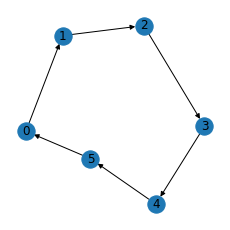

In [1]:
import torch
import torchdrug as td
from torchdrug import data
%matplotlib inline

edge_list = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]]
graph = data.Graph(edge_list, num_node=6)
graph.visualize()

In [2]:
# ! powershell -command "Set-ExecutionPolicy -ExecutionPolicy AllSigned -Scope CurrentUser"
# ! powershell -command "Import-VisualStudioVars -Architecture x64"
# ! powershell -command "$env:LIB += \";C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\libs\" "

Molecules

torch.Size([6, 69])
torch.Size([12, 19])


C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


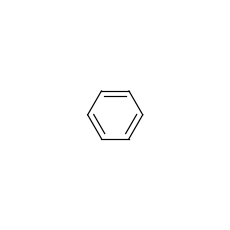

In [3]:
mol = data.Molecule.from_smiles("C1=CC=CC=C1")
mol.visualize()
print(mol.node_feature.shape)
print(mol.edge_feature.shape)

### Graph Operations

C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:858: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4, device='cuda:0')


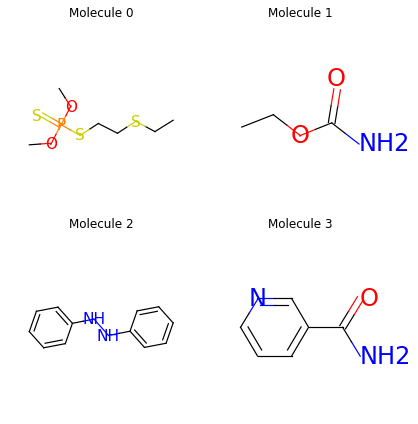

In [4]:
smiles_list = ["CCSCCSP(=S)(OC)OC", "CCOC(=O)N",
               "N(Nc1ccccc1)c2ccccc2", "NC(=O)c1cccnc1"]
mols = data.PackedMolecule.from_smiles(smiles_list)
mols.visualize()
mols = mols.cuda()
print(mols)

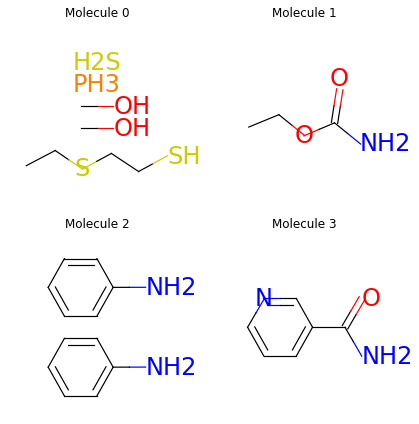

In [5]:
node_in, node_out, bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | \
            (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()

## A Molecule Classifier
Use ClinTox Dataset

### Load and Prepare Dataset Splits

In [6]:
from torchdrug import datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

Loading C:\Users\Mastro/molecule-datasets/clintox.csv: 100%|██████████| 1485/1485 [00:00<00:00, 40242.03it/s]
Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
C:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   7%|▋         | 108/1484 [00:00<00:02, 484.44it/s]C:\Users\Mastro\anaconda3\envs\graphshap

### Define a Graph Neural Network for Classification
We use a GIN (Graph Isomorphism Network)

In [7]:
from torchdrug import core, models, tasks

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)

In [8]:
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

### Train the Model
Launch twice if it reports compliling errors :-)

In [10]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     batch_size=1024, gpus=[0])
solver.train(num_epoch=100)

14:29:10   Preprocess training set
14:29:10   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:10   Epoch 0 begin
14:29:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:11   binary cross entropy: 2.86128
14:29:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:11   Epoch 0 end
14:29:11   duration: 1.23 secs
14:29:11   speed: 1.62 batch / sec
14:29:11   ETA: 2.04 mins
14:29:11   max GPU memory: 746.0 MiB
14:29:11   ------------------------------
14:29:11   average binary cross entropy: 3.24164
14:29:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:11   Epoch 1 begin
14:29:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:11   Epoch 1 end
14:29:11   duration: 0.36 secs
14:29:11   speed: 5.59 batch / sec
14:29:11   ETA: 1.30 mins
14:29:11   max GPU memory: 750.4 MiB
14:29:11   ------------------------------
14:29:11   average binary cross entropy: 2.56882
14:29:11   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:11   Epoch 2 begin
14:29:12   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:12   Epoch 2 end
14:29:12   duration: 0.32 secs
14:29:12   spee

Validate model

In [11]:
solver.evaluate("valid")

14:29:47   Evaluate on valid
14:29:47   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
14:29:47   auprc [CT_TOX]: 0.370289
14:29:47   auprc [FDA_APPROVED]: 0.971221
14:29:47   auroc [CT_TOX]: 0.819012
14:29:47   auroc [FDA_APPROVED]: 0.795491


{'auprc [FDA_APPROVED]': tensor(0.9712, device='cuda:0'),
 'auprc [CT_TOX]': tensor(0.3703, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.7955, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.8190, device='cuda:0')}

save and load

In [12]:
import json

with open("clintox_gin.json", "w") as fout:
    json.dump(solver.config_dict(), fout)
solver.save("clintox_gin.pth")

14:30:20   Save checkpoint to clintox_gin.pth


In [13]:
with open("clintox_gin.json", "r") as fin:
    solver = core.Configurable.load_config_dict(json.load(fin))
solver.load("clintox_gin.pth")

Loading C:\Users\Mastro/molecule-datasets/clintox.csv: 100%|██████████| 1485/1485 [00:00<00:00, 51344.85it/s]
Constructing molecules from SMILES: 100%|██████████| 1484/1484 [00:06<00:00, 237.04it/s]
Loading C:\Users\Mastro/molecule-datasets/clintox.csv: 100%|██████████| 1485/1485 [00:00<00:00, 41359.55it/s]
Constructing molecules from SMILES: 100%|██████████| 1484/1484 [00:05<00:00, 272.47it/s]
Loading C:\Users\Mastro/molecule-datasets/clintox.csv: 100%|██████████| 1485/1485 [00:00<00:00, 59589.58it/s]
Constructing molecules from SMILES: 100%|██████████| 1484/1484 [00:05<00:00, 254.93it/s]

14:30:38   Preprocess training set
14:30:38   Load checkpoint from clintox_gin.pth
